# 第5章补充：高级损失函数与优化器

> **学习目标：**
> - 理解KL散度与JS散度的数学原理和应用场景
> - 掌握Focal Loss解决类别不平衡问题的原理
> - 深入理解Nesterov加速梯度的优势
> - 学习AdamW及其与L2正则化的区别
> - 了解新型优化器RAdam和Lookahead
> - 通过可视化理解损失函数景观
>
> **前置知识：** 05_loss_and_optimizers.ipynb 的内容
>
> **学习时间：** 3-4小时

---

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
from sklearn.datasets import make_classification, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',  # macOS通用
    'PingFang SC',       # macOS系统字体
    'STHeiti',           # 华文黑体
    'Heiti TC',          # 黑体-繁
    'SimHei',            # 黑体
]
plt.rcParams['axes.unicode_minus'] = False

print("环境配置完成！")

环境配置完成！


---

## 1. KL散度与JS散度

### 1.1 信息论基础回顾

在深入学习KL散度之前，我们需要回顾一些信息论的基础概念。

#### 信息熵（Shannon Entropy）

信息熵衡量一个概率分布的**不确定性**或**信息量**：

$$H(P) = -\sum_{i} P(x_i) \log P(x_i)$$

**直观理解：**
- 如果一个事件几乎确定会发生（概率接近1），它携带的信息量很少
- 如果一个事件很罕见（概率很低），它一旦发生就携带很大的信息量

**符号说明：**
| 符号 | 读法 | 含义 |
|------|------|------|
| $H(P)$ | H of P | 分布P的信息熵 |
| $P(x_i)$ | P of x i | 事件$x_i$发生的概率 |
| $\log$ | log | 通常为自然对数（底数e）或以2为底 |

In [2]:
def entropy(p):
    """
    计算离散概率分布的信息熵
    
    参数:
        p: numpy数组, 概率分布, shape: (n_events,)
           所有元素之和应该等于1
    
    返回:
        float: 信息熵值
    
    公式: H(P) = -Σ p(x) * log(p(x))
    
    注意: 为避免 log(0) 的问题，我们添加一个很小的值 epsilon
    """
    # 添加很小的值避免 log(0)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1.0)  # 将概率限制在 [epsilon, 1] 范围内
    
    # 计算熵: -Σ p(x) * log(p(x))
    # np.log 是自然对数
    return -np.sum(p * np.log(p))


# 示例：比较不同分布的熵
# 均匀分布（最大不确定性）
uniform = np.array([0.25, 0.25, 0.25, 0.25])

# 偏斜分布（较低不确定性）
skewed = np.array([0.7, 0.1, 0.1, 0.1])

# 确定性分布（最低不确定性）
certain = np.array([0.97, 0.01, 0.01, 0.01])

print("信息熵比较：")
print(f"均匀分布 {uniform} 的熵: {entropy(uniform):.4f}")
print(f"偏斜分布 {skewed} 的熵: {entropy(skewed):.4f}")
print(f"近似确定分布 {certain} 的熵: {entropy(certain):.4f}")
print("\n结论: 分布越均匀，熵越大；分布越集中，熵越小")

信息熵比较：
均匀分布 [0.25 0.25 0.25 0.25] 的熵: 1.3863
偏斜分布 [0.7 0.1 0.1 0.1] 的熵: 0.9404
近似确定分布 [0.97 0.01 0.01 0.01] 的熵: 0.1677

结论: 分布越均匀，熵越大；分布越集中，熵越小


### 1.2 KL散度（Kullback-Leibler Divergence）

KL散度衡量**两个概率分布之间的差异**，也称为**相对熵**。

$$D_{KL}(P \| Q) = \sum_{i} P(x_i) \log \frac{P(x_i)}{Q(x_i)}$$

**等价形式：**
$$D_{KL}(P \| Q) = \sum_{i} P(x_i) \log P(x_i) - \sum_{i} P(x_i) \log Q(x_i)$$
$$= -H(P) + H(P, Q)$$

其中 $H(P, Q)$ 是**交叉熵**（Cross Entropy）。

**重要性质：**
1. **非负性**：$D_{KL}(P \| Q) \geq 0$，当且仅当 $P = Q$ 时取等号
2. **非对称性**：$D_{KL}(P \| Q) \neq D_{KL}(Q \| P)$（这很重要！）
3. **不满足三角不等式**：KL散度不是真正的距离度量

**直观理解：**
- KL散度衡量"用分布Q去近似分布P时损失了多少信息"
- 如果P是真实分布，Q是模型预测分布，$D_{KL}(P \| Q)$表示模型的"信息损失"

In [3]:
def kl_divergence(p, q):
    """
    计算KL散度 D_KL(P || Q)
    
    参数:
        p: numpy数组, 真实概率分布（参考分布）, shape: (n_events,)
        q: numpy数组, 近似概率分布（模型分布）, shape: (n_events,)
    
    返回:
        float: KL散度值
    
    公式: D_KL(P || Q) = Σ p(x) * log(p(x) / q(x))
    
    注意:
        - KL散度是非对称的: D_KL(P||Q) ≠ D_KL(Q||P)
        - 当q(x)=0但p(x)≠0时，KL散度为无穷大
    """
    # 添加很小的值避免除零和log(0)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1.0)
    q = np.clip(q, epsilon, 1.0)
    
    # KL散度 = Σ p(x) * log(p(x) / q(x))
    #        = Σ p(x) * (log(p(x)) - log(q(x)))
    return np.sum(p * (np.log(p) - np.log(q)))


# 示例：展示KL散度的非对称性
p = np.array([0.4, 0.3, 0.2, 0.1])  # 真实分布
q = np.array([0.25, 0.25, 0.25, 0.25])  # 均匀分布

print("KL散度的非对称性演示：")
print(f"P = {p}")
print(f"Q = {q}")
print(f"\nD_KL(P || Q) = {kl_divergence(p, q):.4f}")
print(f"D_KL(Q || P) = {kl_divergence(q, p):.4f}")
print("\n可以看到两个方向的KL散度是不同的！")

KL散度的非对称性演示：
P = [0.4 0.3 0.2 0.1]
Q = [0.25 0.25 0.25 0.25]

D_KL(P || Q) = 0.1064
D_KL(Q || P) = 0.1218

可以看到两个方向的KL散度是不同的！


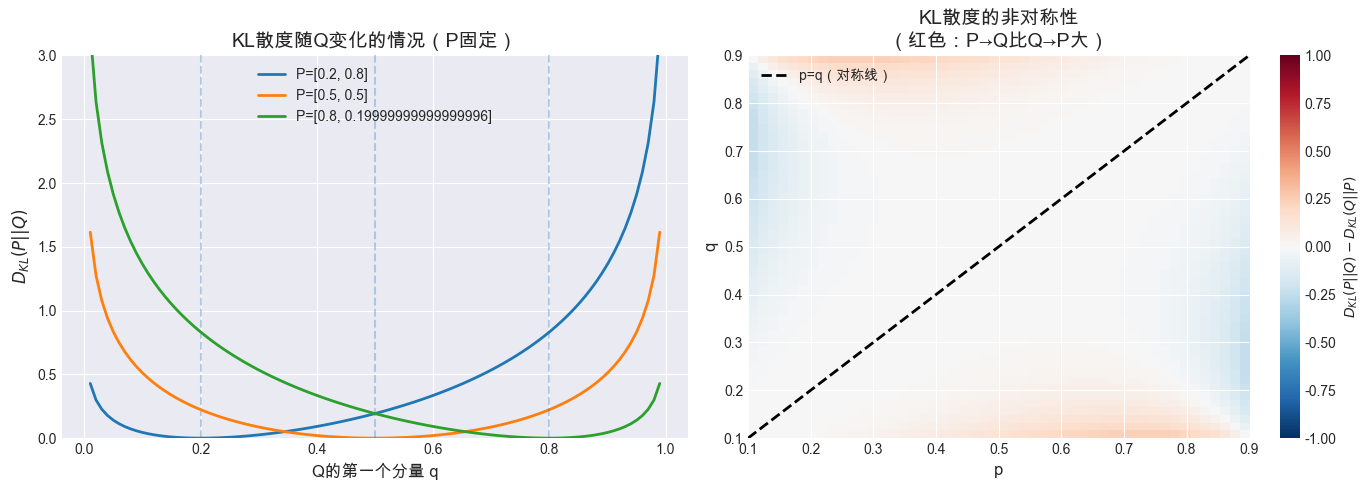

In [4]:
# 可视化KL散度
def visualize_kl_divergence():
    """
    可视化KL散度随分布变化的情况
    
    考虑二元分布 P = [p, 1-p] 和 Q = [q, 1-q]
    绘制 D_KL(P||Q) 作为 q 的函数（固定 p）
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左图：固定P，变化Q
    ax1 = axes[0]
    q_values = np.linspace(0.01, 0.99, 100)
    p_fixed_values = [0.2, 0.5, 0.8]  # 不同的固定P值
    
    for p_fixed in p_fixed_values:
        p_dist = np.array([p_fixed, 1 - p_fixed])
        kl_values = []
        
        for q_val in q_values:
            q_dist = np.array([q_val, 1 - q_val])
            kl_values.append(kl_divergence(p_dist, q_dist))
        
        ax1.plot(q_values, kl_values, label=f'P=[{p_fixed}, {1-p_fixed}]', linewidth=2)
        # 标记最小值点（当Q=P时）
        ax1.axvline(x=p_fixed, linestyle='--', alpha=0.3)
    
    ax1.set_xlabel('Q的第一个分量 q', fontsize=12)
    ax1.set_ylabel('$D_{KL}(P || Q)$', fontsize=12)
    ax1.set_title('KL散度随Q变化的情况（P固定）', fontsize=14)
    ax1.legend()
    ax1.set_ylim(0, 3)
    
    # 右图：KL散度的非对称性热力图
    ax2 = axes[1]
    
    # 创建网格
    p_range = np.linspace(0.1, 0.9, 50)
    q_range = np.linspace(0.1, 0.9, 50)
    P_grid, Q_grid = np.meshgrid(p_range, q_range)
    
    # 计算 D_KL(P||Q) - D_KL(Q||P) 来展示非对称性
    asymmetry = np.zeros_like(P_grid)
    for i in range(len(p_range)):
        for j in range(len(q_range)):
            p_dist = np.array([P_grid[i, j], 1 - P_grid[i, j]])
            q_dist = np.array([Q_grid[i, j], 1 - Q_grid[i, j]])
            asymmetry[i, j] = kl_divergence(p_dist, q_dist) - kl_divergence(q_dist, p_dist)
    
    im = ax2.imshow(asymmetry, extent=[0.1, 0.9, 0.1, 0.9], origin='lower', 
                    cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax2, label='$D_{KL}(P||Q) - D_{KL}(Q||P)$')
    ax2.set_xlabel('p', fontsize=12)
    ax2.set_ylabel('q', fontsize=12)
    ax2.set_title('KL散度的非对称性\n（红色：P→Q比Q→P大）', fontsize=14)
    
    # 对角线上应该为0（对称点）
    ax2.plot([0.1, 0.9], [0.1, 0.9], 'k--', linewidth=2, label='p=q（对称线）')
    ax2.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

visualize_kl_divergence()

### 1.3 JS散度（Jensen-Shannon Divergence）

由于KL散度的非对称性，在某些场景下不太适用。JS散度是KL散度的**对称化版本**：

$$D_{JS}(P \| Q) = \frac{1}{2} D_{KL}(P \| M) + \frac{1}{2} D_{KL}(Q \| M)$$

其中 $M = \frac{1}{2}(P + Q)$ 是P和Q的平均分布。

**JS散度的优点：**
1. **对称性**：$D_{JS}(P \| Q) = D_{JS}(Q \| P)$
2. **有界性**：$0 \leq D_{JS}(P \| Q) \leq \log 2$（使用自然对数时）
3. **平滑性**：即使P或Q中有零概率，JS散度也是有限的

**应用场景：**
- GAN（生成对抗网络）的原始损失函数
- 文本相似度计算
- 分布比较

In [5]:
def js_divergence(p, q):
    """
    计算JS散度（Jensen-Shannon Divergence）
    
    参数:
        p: numpy数组, 概率分布P, shape: (n_events,)
        q: numpy数组, 概率分布Q, shape: (n_events,)
    
    返回:
        float: JS散度值，范围 [0, log(2)]
    
    公式: D_JS(P || Q) = 0.5 * D_KL(P || M) + 0.5 * D_KL(Q || M)
          其中 M = (P + Q) / 2
    
    特点:
        - 对称性: D_JS(P||Q) = D_JS(Q||P)
        - 有界性: 0 ≤ D_JS ≤ log(2)
        - 平滑性: 更稳定，不会出现无穷大
    """
    # 计算中间分布 M = (P + Q) / 2
    m = 0.5 * (p + q)
    
    # JS散度 = 0.5 * KL(P||M) + 0.5 * KL(Q||M)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)


# 验证JS散度的对称性
p = np.array([0.4, 0.3, 0.2, 0.1])
q = np.array([0.25, 0.25, 0.25, 0.25])

print("JS散度的对称性验证：")
print(f"D_JS(P || Q) = {js_divergence(p, q):.6f}")
print(f"D_JS(Q || P) = {js_divergence(q, p):.6f}")
print(f"\n两者相等！JS散度是对称的。")
print(f"\nJS散度的理论上界: log(2) = {np.log(2):.6f}")

JS散度的对称性验证：
D_JS(P || Q) = 0.027866
D_JS(Q || P) = 0.027866

两者相等！JS散度是对称的。

JS散度的理论上界: log(2) = 0.693147


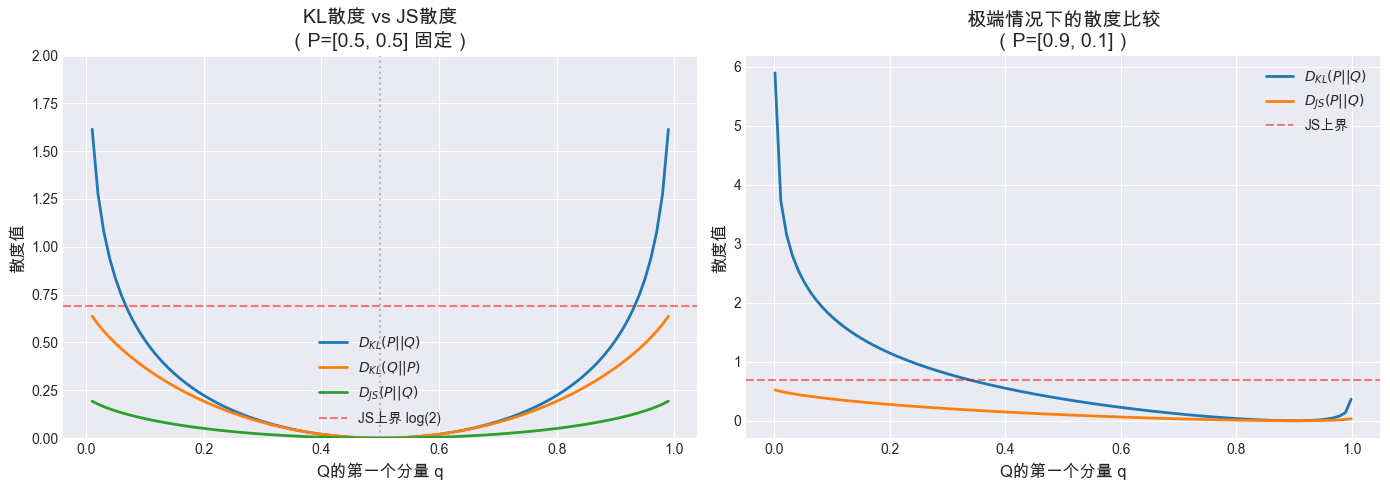

观察结论：
1. KL散度在Q接近边界时会趋向无穷大
2. JS散度始终有界，最大值为log(2)
3. JS散度是对称的，而KL散度不是


In [6]:
# KL散度与JS散度对比
def compare_kl_js():
    """
    对比KL散度和JS散度的行为
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 固定 P = [0.5, 0.5]，变化 Q
    p = np.array([0.5, 0.5])
    q_values = np.linspace(0.01, 0.99, 100)
    
    kl_pq = []
    kl_qp = []
    js_values = []
    
    for q_val in q_values:
        q = np.array([q_val, 1 - q_val])
        kl_pq.append(kl_divergence(p, q))
        kl_qp.append(kl_divergence(q, p))
        js_values.append(js_divergence(p, q))
    
    # 左图：三种散度的比较
    ax1 = axes[0]
    ax1.plot(q_values, kl_pq, label='$D_{KL}(P || Q)$', linewidth=2)
    ax1.plot(q_values, kl_qp, label='$D_{KL}(Q || P)$', linewidth=2)
    ax1.plot(q_values, js_values, label='$D_{JS}(P || Q)$', linewidth=2)
    ax1.axhline(y=np.log(2), linestyle='--', color='red', alpha=0.5, label='JS上界 log(2)')
    ax1.axvline(x=0.5, linestyle=':', color='gray', alpha=0.5)
    
    ax1.set_xlabel('Q的第一个分量 q', fontsize=12)
    ax1.set_ylabel('散度值', fontsize=12)
    ax1.set_title('KL散度 vs JS散度\n（P=[0.5, 0.5] 固定）', fontsize=14)
    ax1.legend()
    ax1.set_ylim(0, 2)
    
    # 右图：处理零概率的能力
    ax2 = axes[1]
    
    # 模拟一个接近零概率的情况
    p = np.array([0.9, 0.1])
    q_values_extreme = np.linspace(0.001, 0.999, 100)
    
    kl_extreme = []
    js_extreme = []
    
    for q_val in q_values_extreme:
        q = np.array([q_val, 1 - q_val])
        kl_extreme.append(kl_divergence(p, q))
        js_extreme.append(js_divergence(p, q))
    
    ax2.plot(q_values_extreme, kl_extreme, label='$D_{KL}(P || Q)$', linewidth=2)
    ax2.plot(q_values_extreme, js_extreme, label='$D_{JS}(P || Q)$', linewidth=2)
    ax2.axhline(y=np.log(2), linestyle='--', color='red', alpha=0.5, label='JS上界')
    
    ax2.set_xlabel('Q的第一个分量 q', fontsize=12)
    ax2.set_ylabel('散度值', fontsize=12)
    ax2.set_title('极端情况下的散度比较\n（P=[0.9, 0.1]）', fontsize=14)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("观察结论：")
    print("1. KL散度在Q接近边界时会趋向无穷大")
    print("2. JS散度始终有界，最大值为log(2)")
    print("3. JS散度是对称的，而KL散度不是")

compare_kl_js()

### 1.4 在深度学习中的应用

**KL散度的应用：**
1. **变分自编码器（VAE）**：用于衡量编码器输出的分布与先验分布的差异
2. **知识蒸馏**：学生网络学习教师网络的软标签
3. **强化学习**：策略更新时的约束

**JS散度的应用：**
1. **原始GAN**：判别器优化目标与JS散度相关
2. **文本相似度**：比较文档的词分布

In [7]:
# 知识蒸馏中的KL散度应用示例
def knowledge_distillation_demo():
    """
    演示知识蒸馏中KL散度的作用
    
    知识蒸馏的核心思想：
    - 教师网络（大模型）输出软标签（soft labels）
    - 学生网络（小模型）学习这些软标签
    - 软标签包含类别之间的相似性信息
    """
    print("=" * 60)
    print("知识蒸馏中的KL散度应用")
    print("=" * 60)
    
    # 假设我们有一个3分类问题（猫、狗、狮子）
    classes = ['猫', '狗', '狮子']
    
    # 真实标签（硬标签）：这是一只猫
    hard_label = np.array([1.0, 0.0, 0.0])
    
    # 教师网络的软标签：猫和狮子有一定相似性
    teacher_soft = np.array([0.85, 0.05, 0.10])
    
    # 学生网络的输出（两种情况）
    # 情况1：只学习硬标签
    student_hard = np.array([0.90, 0.05, 0.05])
    # 情况2：学习软标签
    student_soft = np.array([0.82, 0.06, 0.12])
    
    print(f"\n真实标签（硬标签）: {dict(zip(classes, hard_label))}")
    print(f"教师网络软标签: {dict(zip(classes, teacher_soft))}")
    print(f"学生网络（学习硬标签后）: {dict(zip(classes, student_hard))}")
    print(f"学生网络（学习软标签后）: {dict(zip(classes, student_soft))}")
    
    # 计算KL散度
    kl_teacher_student_hard = kl_divergence(teacher_soft, student_hard)
    kl_teacher_student_soft = kl_divergence(teacher_soft, student_soft)
    
    print(f"\nKL散度（教师 || 学习硬标签的学生）: {kl_teacher_student_hard:.4f}")
    print(f"KL散度（教师 || 学习软标签的学生）: {kl_teacher_student_soft:.4f}")
    
    print("\n结论：学习软标签的学生网络更接近教师网络，")
    print("因为它学到了'猫和狮子有一定相似性'这个隐含知识。")

knowledge_distillation_demo()

知识蒸馏中的KL散度应用

真实标签（硬标签）: {'猫': 1.0, '狗': 0.0, '狮子': 0.0}
教师网络软标签: {'猫': 0.85, '狗': 0.05, '狮子': 0.1}
学生网络（学习硬标签后）: {'猫': 0.9, '狗': 0.05, '狮子': 0.05}
学生网络（学习软标签后）: {'猫': 0.82, '狗': 0.06, '狮子': 0.12}

KL散度（教师 || 学习硬标签的学生）: 0.0207
KL散度（教师 || 学习软标签的学生）: 0.0032

结论：学习软标签的学生网络更接近教师网络，
因为它学到了'猫和狮子有一定相似性'这个隐含知识。


---

## 2. Focal Loss（解决类别不平衡）

### 2.1 问题背景：类别不平衡

在许多实际应用中，数据集存在严重的类别不平衡问题：
- **目标检测**：背景类样本远多于目标类
- **欺诈检测**：正常交易远多于欺诈交易
- **医学诊断**：健康样本远多于患病样本

**标准交叉熵的问题：**
- 大量简单负样本（easy negatives）主导了损失
- 模型倾向于预测多数类
- 少数类的学习被"淹没"

In [8]:
def cross_entropy(y_true, y_pred):
    """
    标准二分类交叉熵损失
    
    参数:
        y_true: 真实标签, 0或1
        y_pred: 预测概率, [0, 1]
    
    返回:
        float: 交叉熵损失
    
    公式: CE = -[y*log(p) + (1-y)*log(1-p)]
    """
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    if y_true == 1:
        return -np.log(y_pred)
    else:
        return -np.log(1 - y_pred)


# 演示类别不平衡问题
print("类别不平衡导致的损失主导问题：")
print("\n假设有100个样本：95个负样本，5个正样本")
print("模型对所有样本都预测为负类（概率0.1）")

# 简单负样本（模型很确信是负类，且确实是负类）
easy_neg_loss = cross_entropy(0, 0.1)  # 真实是0，预测概率0.1
# 困难正样本（模型预测为负类，但实际是正类）
hard_pos_loss = cross_entropy(1, 0.1)  # 真实是1，预测概率0.1

print(f"\n单个简单负样本的损失: {easy_neg_loss:.4f}")
print(f"单个困难正样本的损失: {hard_pos_loss:.4f}")

# 计算总损失
total_easy_neg = 95 * easy_neg_loss
total_hard_pos = 5 * hard_pos_loss
total_loss = total_easy_neg + total_hard_pos

print(f"\n95个简单负样本的总损失: {total_easy_neg:.4f} ({total_easy_neg/total_loss*100:.1f}%)")
print(f"5个困难正样本的总损失: {total_hard_pos:.4f} ({total_hard_pos/total_loss*100:.1f}%)")
print(f"\n虽然正样本单个损失大，但负样本数量多，仍然主导总损失！")

类别不平衡导致的损失主导问题：

假设有100个样本：95个负样本，5个正样本
模型对所有样本都预测为负类（概率0.1）

单个简单负样本的损失: 0.1054
单个困难正样本的损失: 2.3026

95个简单负样本的总损失: 10.0092 (46.5%)
5个困难正样本的总损失: 11.5129 (53.5%)

虽然正样本单个损失大，但负样本数量多，仍然主导总损失！


### 2.2 Focal Loss原理

Focal Loss由Facebook AI Research（FAIR）在RetinaNet论文中提出，专门解决目标检测中的类别不平衡问题。

**核心思想：降低简单样本的权重，让模型关注困难样本**

$$FL(p_t) = -\alpha_t (1 - p_t)^\gamma \log(p_t)$$

其中：
- $p_t$：模型对正确类别的预测概率
  - 当真实标签$y=1$时，$p_t = p$
  - 当真实标签$y=0$时，$p_t = 1-p$
- $(1 - p_t)^\gamma$：**调制因子（modulating factor）**
  - 当样本被正确分类且置信度高时，$p_t$接近1，调制因子接近0
  - 当样本分类困难时，$p_t$较小，调制因子较大
- $\gamma$：**聚焦参数（focusing parameter）**
  - $\gamma = 0$ 时，Focal Loss退化为标准交叉熵
  - $\gamma$越大，对简单样本的抑制越强
  - 论文推荐$\gamma = 2$
- $\alpha_t$：**平衡因子**，用于进一步平衡正负样本

In [9]:
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """
    Focal Loss - 解决类别不平衡问题的损失函数
    
    参数:
        y_true: 真实标签, 0或1
        y_pred: 预测概率, [0, 1]
        gamma: 聚焦参数，控制对简单样本的抑制程度，默认2.0
               gamma=0时退化为交叉熵
               gamma越大，对简单样本的抑制越强
        alpha: 平衡因子，正样本的权重，默认0.25
               负样本权重为(1-alpha)
    
    返回:
        float: Focal Loss值
    
    公式: FL(p_t) = -α_t * (1 - p_t)^γ * log(p_t)
    
    核心思想:
        - (1 - p_t)^γ 是调制因子
        - 当样本易分类(p_t大)时，调制因子小，损失被抑制
        - 当样本难分类(p_t小)时，调制因子大，损失保持
    """
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # 计算 p_t（对正确类别的预测概率）
    if y_true == 1:
        p_t = y_pred
        alpha_t = alpha
    else:
        p_t = 1 - y_pred
        alpha_t = 1 - alpha
    
    # Focal Loss = -α_t * (1 - p_t)^γ * log(p_t)
    # 分解步骤:
    # 1. (1 - p_t)^γ: 调制因子，抑制简单样本
    modulating_factor = (1 - p_t) ** gamma
    # 2. -log(p_t): 标准交叉熵
    ce_loss = -np.log(p_t)
    # 3. 组合得到Focal Loss
    focal = alpha_t * modulating_factor * ce_loss
    
    return focal


# 比较不同gamma值下的Focal Loss
print("Focal Loss vs 交叉熵 对比：")
print("\n假设有一个正样本（y=1），模型预测概率为p")
print("-" * 60)

p_values = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
gamma_values = [0, 1, 2, 5]

print(f"{'p值':>6} | {'CE(γ=0)':>10} | {'FL(γ=1)':>10} | {'FL(γ=2)':>10} | {'FL(γ=5)':>10}")
print("-" * 60)

for p in p_values:
    losses = [focal_loss(1, p, gamma=g, alpha=1.0) for g in gamma_values]
    print(f"{p:>6.2f} | {losses[0]:>10.4f} | {losses[1]:>10.4f} | {losses[2]:>10.4f} | {losses[3]:>10.4f}")

print("\n观察：")
print("- 当p=0.1（困难样本）时，各个gamma值的损失差异不大")
print("- 当p=0.95（简单样本）时，gamma越大，损失被抑制得越厉害")

Focal Loss vs 交叉熵 对比：

假设有一个正样本（y=1），模型预测概率为p
------------------------------------------------------------
    p值 |    CE(γ=0) |    FL(γ=1) |    FL(γ=2) |    FL(γ=5)
------------------------------------------------------------
  0.10 |     2.3026 |     2.0723 |     1.8651 |     1.3597
  0.30 |     1.2040 |     0.8428 |     0.5899 |     0.2024
  0.50 |     0.6931 |     0.3466 |     0.1733 |     0.0217
  0.70 |     0.3567 |     0.1070 |     0.0321 |     0.0009
  0.90 |     0.1054 |     0.0105 |     0.0011 |     0.0000
  0.95 |     0.0513 |     0.0026 |     0.0001 |     0.0000

观察：
- 当p=0.1（困难样本）时，各个gamma值的损失差异不大
- 当p=0.95（简单样本）时，gamma越大，损失被抑制得越厉害


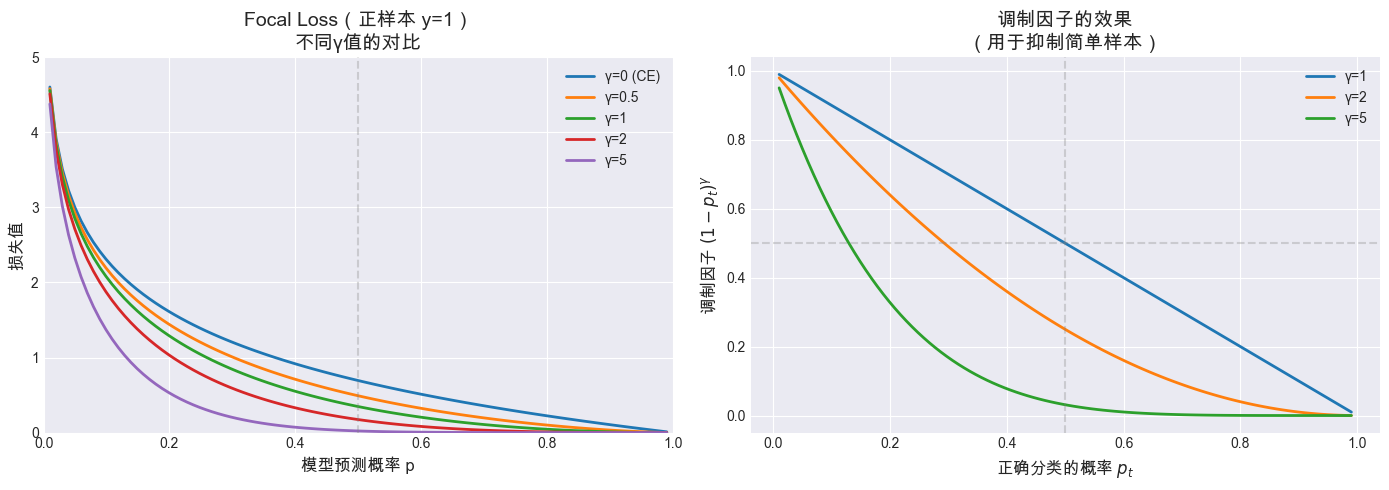

关键观察：
1. 当p_t接近1时（简单样本），调制因子接近0，损失被大幅抑制
2. 当p_t接近0时（困难样本），调制因子接近1，损失基本不变
3. γ越大，对简单样本的抑制效果越强


In [10]:
# 可视化Focal Loss
def visualize_focal_loss():
    """
    可视化Focal Loss与交叉熵的对比
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    p_range = np.linspace(0.01, 0.99, 100)
    
    # 左图：不同gamma值下的Focal Loss（正样本）
    ax1 = axes[0]
    
    for gamma in [0, 0.5, 1, 2, 5]:
        losses = [focal_loss(1, p, gamma=gamma, alpha=1.0) for p in p_range]
        label = f'γ={gamma}' + (' (CE)' if gamma == 0 else '')
        ax1.plot(p_range, losses, label=label, linewidth=2)
    
    ax1.set_xlabel('模型预测概率 p', fontsize=12)
    ax1.set_ylabel('损失值', fontsize=12)
    ax1.set_title('Focal Loss（正样本 y=1）\n不同γ值的对比', fontsize=14)
    ax1.legend()
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 5)
    ax1.axvline(x=0.5, linestyle='--', color='gray', alpha=0.3)
    
    # 右图：调制因子 (1-p_t)^γ 的效果
    ax2 = axes[1]
    
    for gamma in [1, 2, 5]:
        modulating = (1 - p_range) ** gamma
        ax2.plot(p_range, modulating, label=f'γ={gamma}', linewidth=2)
    
    ax2.set_xlabel('正确分类的概率 $p_t$', fontsize=12)
    ax2.set_ylabel('调制因子 $(1-p_t)^γ$', fontsize=12)
    ax2.set_title('调制因子的效果\n（用于抑制简单样本）', fontsize=14)
    ax2.legend()
    ax2.axhline(y=0.5, linestyle='--', color='gray', alpha=0.3)
    ax2.axvline(x=0.5, linestyle='--', color='gray', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("关键观察：")
    print("1. 当p_t接近1时（简单样本），调制因子接近0，损失被大幅抑制")
    print("2. 当p_t接近0时（困难样本），调制因子接近1，损失基本不变")
    print("3. γ越大，对简单样本的抑制效果越强")

visualize_focal_loss()

不平衡数据集上的损失函数对比

数据集：50个正样本，1000个负样本
不平衡比例：1:20

交叉熵损失分解：
  正样本损失: 115.13 (52.2%)
  负样本损失: 105.36 (47.8%)
  总损失: 220.49

Focal Loss分解（γ=2, α=0.25）：
  正样本损失: 23.31 (96.7%)
  负样本损失: 0.79 (3.3%)
  总损失: 24.10

结论：
- 交叉熵损失中，负样本主导了梯度
- Focal Loss通过降低简单负样本的权重，让正样本获得更多关注


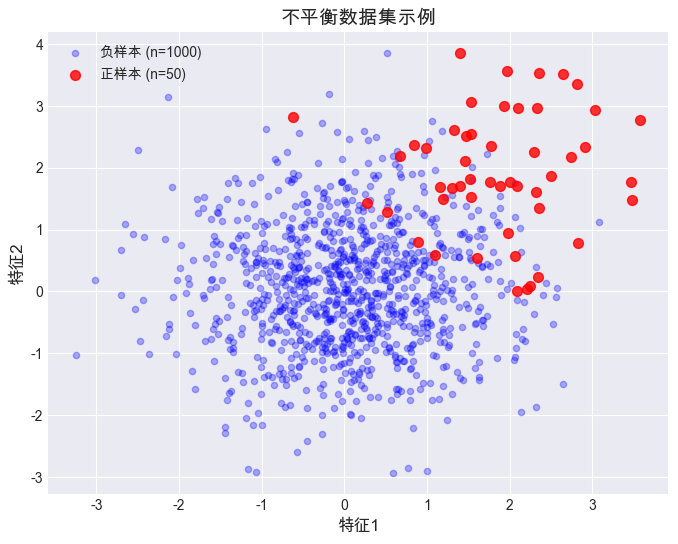

In [11]:
# 实战：在不平衡数据集上比较交叉熵和Focal Loss
def compare_ce_focal_imbalanced():
    """
    在不平衡数据集上比较交叉熵和Focal Loss的训练效果
    """
    print("=" * 60)
    print("不平衡数据集上的损失函数对比")
    print("=" * 60)
    
    # 创建不平衡数据集
    # 正负样本比例 1:20
    np.random.seed(42)
    n_positive = 50
    n_negative = 1000
    
    # 生成正样本（类别1）
    X_pos = np.random.randn(n_positive, 2) + np.array([2, 2])
    y_pos = np.ones(n_positive)
    
    # 生成负样本（类别0）
    X_neg = np.random.randn(n_negative, 2)
    y_neg = np.zeros(n_negative)
    
    X = np.vstack([X_pos, X_neg])
    y = np.hstack([y_pos, y_neg])
    
    # 打乱数据
    shuffle_idx = np.random.permutation(len(y))
    X, y = X[shuffle_idx], y[shuffle_idx]
    
    print(f"\n数据集：{n_positive}个正样本，{n_negative}个负样本")
    print(f"不平衡比例：1:{n_negative//n_positive}")
    
    # 假设一个简单的模型预测
    # 模型倾向于预测为负类，所有样本的正类概率都是0.1
    y_pred_biased = np.full(len(y), 0.1)
    
    # 计算交叉熵损失
    ce_losses = [cross_entropy(yt, yp) for yt, yp in zip(y, y_pred_biased)]
    total_ce = np.sum(ce_losses)
    ce_pos = np.sum([ce_losses[i] for i in range(len(y)) if y[i] == 1])
    ce_neg = np.sum([ce_losses[i] for i in range(len(y)) if y[i] == 0])
    
    # 计算Focal Loss
    fl_losses = [focal_loss(yt, yp, gamma=2, alpha=0.25) for yt, yp in zip(y, y_pred_biased)]
    total_fl = np.sum(fl_losses)
    fl_pos = np.sum([fl_losses[i] for i in range(len(y)) if y[i] == 1])
    fl_neg = np.sum([fl_losses[i] for i in range(len(y)) if y[i] == 0])
    
    print(f"\n交叉熵损失分解：")
    print(f"  正样本损失: {ce_pos:.2f} ({ce_pos/total_ce*100:.1f}%)")
    print(f"  负样本损失: {ce_neg:.2f} ({ce_neg/total_ce*100:.1f}%)")
    print(f"  总损失: {total_ce:.2f}")
    
    print(f"\nFocal Loss分解（γ=2, α=0.25）：")
    print(f"  正样本损失: {fl_pos:.2f} ({fl_pos/total_fl*100:.1f}%)")
    print(f"  负样本损失: {fl_neg:.2f} ({fl_neg/total_fl*100:.1f}%)")
    print(f"  总损失: {total_fl:.2f}")
    
    print("\n结论：")
    print("- 交叉熵损失中，负样本主导了梯度")
    print("- Focal Loss通过降低简单负样本的权重，让正样本获得更多关注")
    
    # 可视化数据分布
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(X[y==0, 0], X[y==0, 1], c='blue', alpha=0.3, label=f'负样本 (n={n_negative})', s=20)
    ax.scatter(X[y==1, 0], X[y==1, 1], c='red', alpha=0.8, label=f'正样本 (n={n_positive})', s=50)
    ax.set_xlabel('特征1', fontsize=12)
    ax.set_ylabel('特征2', fontsize=12)
    ax.set_title('不平衡数据集示例', fontsize=14)
    ax.legend()
    plt.show()

compare_ce_focal_imbalanced()

---

## 3. Nesterov加速梯度（NAG）

### 3.1 动量法回顾

标准动量法的更新公式：

$$v_t = \beta v_{t-1} + \nabla L(\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \alpha v_t$$

其中：
- $v_t$：当前速度（velocity）
- $\beta$：动量系数（通常0.9）
- $\alpha$：学习率
- $\nabla L(\theta_{t-1})$：当前位置的梯度

**问题：** 动量法在接近最优点时可能会"冲过头"，因为它只考虑当前位置的梯度。

### 3.2 Nesterov动量

Nesterov的核心思想：**"看一步，走一步"（lookahead）**

既然我们知道动量会带我们往某个方向走，为什么不先"看看"那个位置的梯度，再决定如何调整？

**更新公式：**

$$v_t = \beta v_{t-1} + \nabla L(\theta_{t-1} - \alpha \beta v_{t-1})$$
$$\theta_t = \theta_{t-1} - \alpha v_t$$

**与标准动量的区别：**
- 标准动量：计算**当前位置**的梯度
- Nesterov动量：计算**预测位置**（$\theta_{t-1} - \alpha \beta v_{t-1}$）的梯度

**直观理解：**
1. 先按照动量方向"假装"走一步
2. 在新位置计算梯度
3. 用这个梯度来修正方向

In [12]:
class NesterovMomentum:
    """
    Nesterov加速梯度（NAG）优化器 - 从零实现
    
    核心思想：先按动量方向"预测"下一步位置，然后在预测位置计算梯度
    这种"lookahead"机制可以更快地纠正方向，避免震荡
    
    属性:
        learning_rate: 学习率，控制每次更新的步长
        momentum: 动量系数，控制历史梯度的影响，通常设为0.9
        velocity: 速度向量，累积的梯度方向
    """
    
    def __init__(self, learning_rate=0.01, momentum=0.9):
        """
        初始化Nesterov优化器
        
        参数:
            learning_rate: float, 学习率，默认0.01
            momentum: float, 动量系数，默认0.9
        """
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity = None  # 速度向量，首次更新时初始化
    
    def get_lookahead_position(self, params):
        """
        计算预测位置（lookahead position）
        
        这是Nesterov动量的关键：先按动量方向"走一步"
        
        参数:
            params: numpy数组, 当前参数位置
        
        返回:
            numpy数组, 预测位置
        """
        if self.velocity is None:
            # 首次调用，速度为0，预测位置就是当前位置
            return params.copy()
        else:
            # 预测位置 = 当前位置 - 学习率 * 动量 * 速度
            return params - self.learning_rate * self.momentum * self.velocity
    
    def update(self, params, grads):
        """
        执行一步Nesterov更新
        
        参数:
            params: numpy数组, 当前参数
            grads: numpy数组, 在lookahead位置计算的梯度（重要！）
        
        返回:
            numpy数组, 更新后的参数
        
        更新公式:
            v_t = β * v_{t-1} + grad(θ - α*β*v_{t-1})
            θ_t = θ_{t-1} - α * v_t
        """
        # 初始化速度向量（与参数形状相同，初始值为0）
        if self.velocity is None:
            self.velocity = np.zeros_like(params)
        
        # 更新速度：v = β * v + grad
        # 注意：grads应该是在lookahead位置计算的梯度
        self.velocity = self.momentum * self.velocity + grads
        
        # 更新参数：θ = θ - α * v
        params = params - self.learning_rate * self.velocity
        
        return params


class StandardMomentum:
    """
    标准动量优化器 - 用于对比
    """
    
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity = None
    
    def update(self, params, grads):
        if self.velocity is None:
            self.velocity = np.zeros_like(params)
        
        # 标准动量更新
        self.velocity = self.momentum * self.velocity + grads
        params = params - self.learning_rate * self.velocity
        
        return params


print("Nesterov优化器类已定义")

Nesterov优化器类已定义


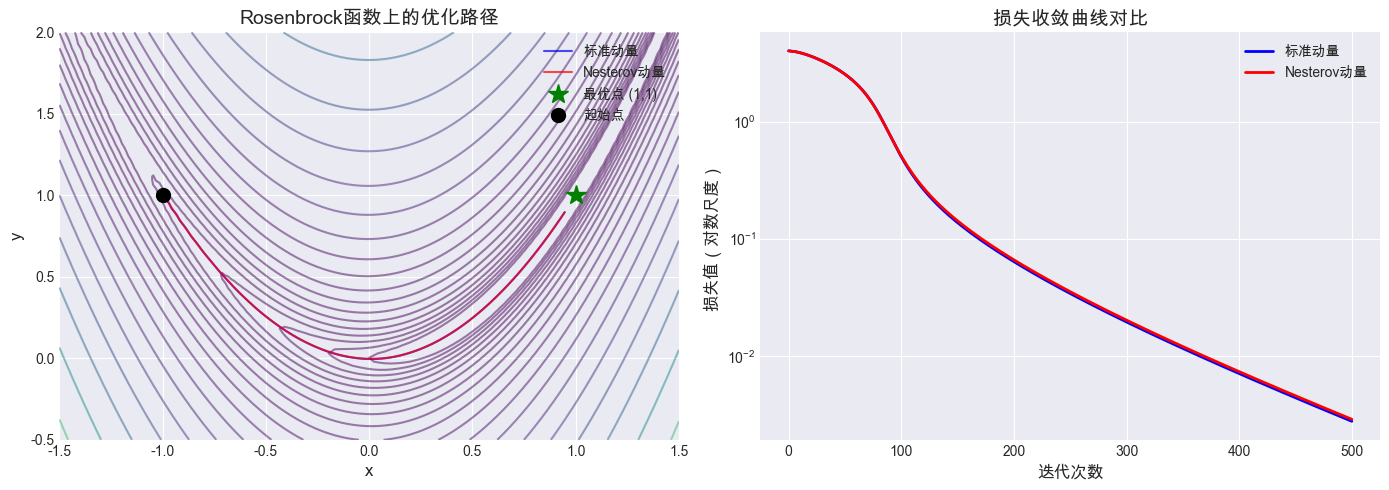

最终损失值：
  标准动量: 0.002802
  Nesterov: 0.002914


In [13]:
# 可视化Nesterov vs 标准动量
def compare_nesterov_momentum():
    """
    在一个二维优化问题上比较Nesterov动量和标准动量
    
    使用Rosenbrock函数：f(x,y) = (1-x)^2 + 100(y-x^2)^2
    这是一个经典的测试函数，有一个狭长的山谷
    """
    # Rosenbrock函数
    def rosenbrock(x, y):
        return (1 - x)**2 + 100 * (y - x**2)**2
    
    # Rosenbrock函数的梯度
    def rosenbrock_grad(params):
        x, y = params
        dx = -2 * (1 - x) - 400 * x * (y - x**2)
        dy = 200 * (y - x**2)
        return np.array([dx, dy])
    
    # 初始点
    start = np.array([-1.0, 1.0])
    
    # 创建优化器
    lr = 0.001
    momentum = 0.9
    n_steps = 500
    
    # 标准动量优化
    std_optimizer = StandardMomentum(learning_rate=lr, momentum=momentum)
    std_params = start.copy()
    std_history = [std_params.copy()]
    
    for _ in range(n_steps):
        grads = rosenbrock_grad(std_params)
        std_params = std_optimizer.update(std_params, grads)
        std_history.append(std_params.copy())
    
    # Nesterov动量优化
    nag_optimizer = NesterovMomentum(learning_rate=lr, momentum=momentum)
    nag_params = start.copy()
    nag_history = [nag_params.copy()]
    
    for _ in range(n_steps):
        # 关键区别：先获取lookahead位置
        lookahead = nag_optimizer.get_lookahead_position(nag_params)
        # 在lookahead位置计算梯度
        grads = rosenbrock_grad(lookahead)
        nag_params = nag_optimizer.update(nag_params, grads)
        nag_history.append(nag_params.copy())
    
    std_history = np.array(std_history)
    nag_history = np.array(nag_history)
    
    # 可视化
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左图：等高线图上的优化路径
    ax1 = axes[0]
    
    # 绘制等高线
    x_range = np.linspace(-1.5, 1.5, 100)
    y_range = np.linspace(-0.5, 2, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = rosenbrock(X, Y)
    
    ax1.contour(X, Y, Z, levels=np.logspace(0, 3, 20), cmap='viridis', alpha=0.5)
    ax1.plot(std_history[:, 0], std_history[:, 1], 'b-', linewidth=1.5, 
             label='标准动量', alpha=0.7)
    ax1.plot(nag_history[:, 0], nag_history[:, 1], 'r-', linewidth=1.5, 
             label='Nesterov动量', alpha=0.7)
    ax1.plot(1, 1, 'g*', markersize=15, label='最优点 (1,1)')
    ax1.plot(start[0], start[1], 'ko', markersize=10, label='起始点')
    
    ax1.set_xlabel('x', fontsize=12)
    ax1.set_ylabel('y', fontsize=12)
    ax1.set_title('Rosenbrock函数上的优化路径', fontsize=14)
    ax1.legend()
    
    # 右图：损失收敛曲线
    ax2 = axes[1]
    
    std_losses = [rosenbrock(p[0], p[1]) for p in std_history]
    nag_losses = [rosenbrock(p[0], p[1]) for p in nag_history]
    
    ax2.semilogy(std_losses, 'b-', label='标准动量', linewidth=2)
    ax2.semilogy(nag_losses, 'r-', label='Nesterov动量', linewidth=2)
    
    ax2.set_xlabel('迭代次数', fontsize=12)
    ax2.set_ylabel('损失值（对数尺度）', fontsize=12)
    ax2.set_title('损失收敛曲线对比', fontsize=14)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"最终损失值：")
    print(f"  标准动量: {std_losses[-1]:.6f}")
    print(f"  Nesterov: {nag_losses[-1]:.6f}")

compare_nesterov_momentum()

---

## 4. AdamW与权重衰减

### 4.1 L2正则化 vs 权重衰减

**很多人认为L2正则化和权重衰减是等价的，但在自适应学习率优化器中，它们是不同的！**

#### L2正则化

在损失函数中添加L2惩罚项：
$$L_{reg} = L + \frac{\lambda}{2} \|\theta\|^2$$

梯度变为：
$$\nabla L_{reg} = \nabla L + \lambda \theta$$

#### 权重衰减（Weight Decay）

直接在参数更新时减去一部分参数值：
$$\theta_{t+1} = \theta_t - \alpha \nabla L - \alpha \lambda \theta_t$$

**关键区别：**
在SGD中，两者数学上等价。但在Adam中：
- L2正则化的梯度也会被自适应学习率缩放
- 权重衰减直接作用于参数，不受自适应学习率影响

In [14]:
class Adam:
    """
    Adam优化器 - 从零实现
    
    Adam = Adaptive Moment Estimation
    结合了动量和RMSprop的优点
    
    核心思想:
        - 一阶矩估计(m): 梯度的指数移动平均，类似动量
        - 二阶矩估计(v): 梯度平方的指数移动平均，用于自适应学习率
    """
    
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """
        初始化Adam优化器
        
        参数:
            learning_rate: 学习率，默认0.001
            beta1: 一阶矩估计的衰减率，默认0.9
            beta2: 二阶矩估计的衰减率，默认0.999
            epsilon: 数值稳定性常数，防止除零
        """
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None  # 一阶矩估计
        self.v = None  # 二阶矩估计
        self.t = 0     # 时间步
    
    def update(self, params, grads):
        """
        执行一步Adam更新
        
        更新公式:
            m_t = β1 * m_{t-1} + (1 - β1) * g_t           # 一阶矩
            v_t = β2 * v_{t-1} + (1 - β2) * g_t^2         # 二阶矩
            m̂_t = m_t / (1 - β1^t)                        # 偏差修正
            v̂_t = v_t / (1 - β2^t)                        # 偏差修正
            θ_t = θ_{t-1} - α * m̂_t / (√v̂_t + ε)          # 参数更新
        """
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)
        
        self.t += 1
        
        # 更新一阶矩（动量）
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        
        # 更新二阶矩（梯度平方的移动平均）
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grads ** 2)
        
        # 偏差修正（因为m和v初始为0，初期估计会偏小）
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        
        # 参数更新
        params = params - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        
        return params


class AdamW:
    """
    AdamW优化器 - 从零实现
    
    AdamW = Adam with decoupled Weight decay
    
    与Adam的区别：
        - Adam使用L2正则化：正则化梯度也被自适应学习率影响
        - AdamW使用解耦的权重衰减：直接在参数上衰减，不受自适应学习率影响
    
    这个区别在实践中很重要，AdamW通常能获得更好的泛化性能
    """
    
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, 
                 epsilon=1e-8, weight_decay=0.01):
        """
        初始化AdamW优化器
        
        参数:
            learning_rate: 学习率，默认0.001
            beta1: 一阶矩估计的衰减率，默认0.9
            beta2: 二阶矩估计的衰减率，默认0.999
            epsilon: 数值稳定性常数
            weight_decay: 权重衰减系数，默认0.01（不是L2系数！）
        """
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay  # 解耦的权重衰减
        self.m = None
        self.v = None
        self.t = 0
    
    def update(self, params, grads):
        """
        执行一步AdamW更新
        
        与Adam的区别在最后一步：
            θ_t = θ_{t-1} - α * m̂_t / (√v̂_t + ε) - α * λ * θ_{t-1}
                                                    ^^^^^^^^^^^^^^^^
                                                    解耦的权重衰减
        
        注意：权重衰减项不通过Adam的自适应学习率
        """
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)
        
        self.t += 1
        
        # 更新一阶矩和二阶矩（与Adam相同）
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grads ** 2)
        
        # 偏差修正
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        
        # 参数更新（关键区别！）
        # 第一部分：Adam更新
        adam_update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        # 第二部分：解耦的权重衰减（直接作用于参数）
        weight_decay_update = self.lr * self.weight_decay * params
        
        params = params - adam_update - weight_decay_update
        
        return params


print("Adam和AdamW优化器类已定义")

Adam和AdamW优化器类已定义


Adam vs AdamW: 权重衰减的区别


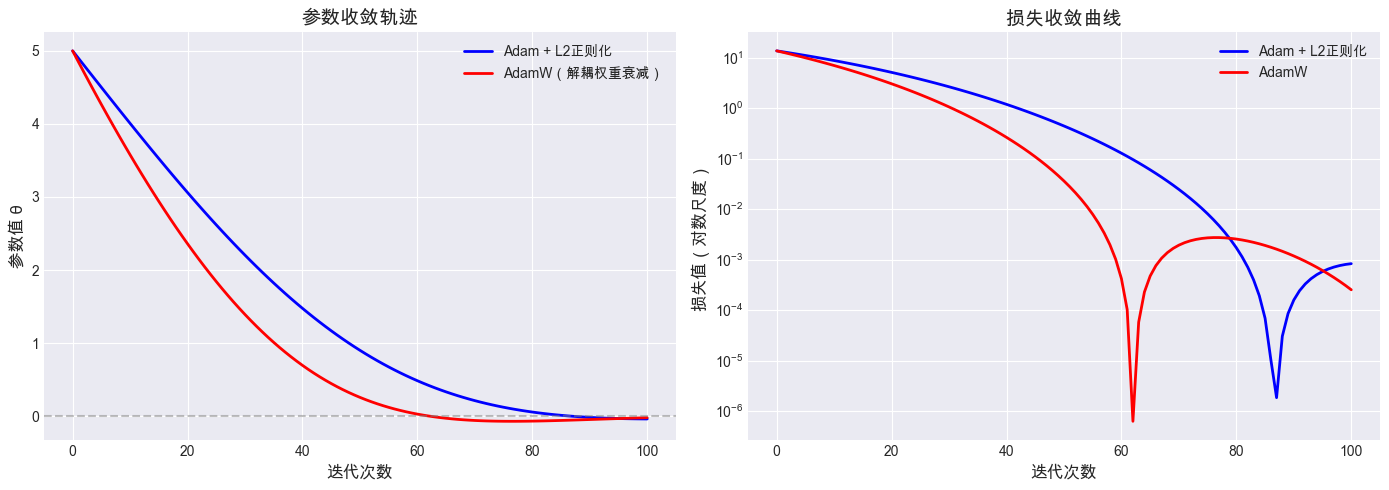


最终参数值：
  Adam + L2: θ = -0.039004
  AdamW:     θ = -0.021493

关键区别：
  - Adam + L2: 正则化梯度被自适应学习率缩放，收敛行为不同
  - AdamW: 权重衰减直接作用，不受自适应学习率影响


In [15]:
# 可视化Adam vs AdamW的区别
def compare_adam_adamw():
    """
    比较Adam（带L2正则化）和AdamW（带权重衰减）的行为差异
    """
    print("=" * 60)
    print("Adam vs AdamW: 权重衰减的区别")
    print("=" * 60)
    
    # 简单的二次损失函数 + L2正则化
    # L(θ) = 0.5 * θ^2 + 0.5 * λ * θ^2 = 0.5 * (1 + λ) * θ^2
    # 梯度: ∇L = (1 + λ) * θ
    
    lambda_reg = 0.1  # 正则化系数
    
    def loss_with_l2(theta, lambda_reg=0.1):
        return 0.5 * theta**2 + 0.5 * lambda_reg * theta**2
    
    def grad_with_l2(theta, lambda_reg=0.1):
        # 损失梯度 + L2正则化梯度
        return theta + lambda_reg * theta
    
    def grad_without_l2(theta):
        # 纯损失梯度（不含正则化）
        return theta
    
    # 初始参数
    theta_init = 5.0
    n_steps = 100
    
    # Adam + L2正则化
    adam_l2 = Adam(learning_rate=0.1)
    theta_adam_l2 = theta_init
    history_adam_l2 = [theta_adam_l2]
    
    for _ in range(n_steps):
        grad = grad_with_l2(theta_adam_l2, lambda_reg)
        theta_adam_l2 = adam_l2.update(np.array([theta_adam_l2]), np.array([grad]))[0]
        history_adam_l2.append(theta_adam_l2)
    
    # AdamW（解耦权重衰减）
    adamw = AdamW(learning_rate=0.1, weight_decay=lambda_reg)
    theta_adamw = theta_init
    history_adamw = [theta_adamw]
    
    for _ in range(n_steps):
        # 注意：AdamW只传入损失的梯度，不含正则化项
        grad = grad_without_l2(theta_adamw)
        theta_adamw = adamw.update(np.array([theta_adamw]), np.array([grad]))[0]
        history_adamw.append(theta_adamw)
    
    # 可视化
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左图：参数轨迹
    ax1 = axes[0]
    ax1.plot(history_adam_l2, 'b-', label='Adam + L2正则化', linewidth=2)
    ax1.plot(history_adamw, 'r-', label='AdamW（解耦权重衰减）', linewidth=2)
    ax1.axhline(y=0, linestyle='--', color='gray', alpha=0.5)
    ax1.set_xlabel('迭代次数', fontsize=12)
    ax1.set_ylabel('参数值 θ', fontsize=12)
    ax1.set_title('参数收敛轨迹', fontsize=14)
    ax1.legend()
    
    # 右图：损失轨迹
    ax2 = axes[1]
    losses_adam_l2 = [loss_with_l2(t, lambda_reg) for t in history_adam_l2]
    losses_adamw = [loss_with_l2(t, lambda_reg) for t in history_adamw]
    
    ax2.semilogy(losses_adam_l2, 'b-', label='Adam + L2正则化', linewidth=2)
    ax2.semilogy(losses_adamw, 'r-', label='AdamW', linewidth=2)
    ax2.set_xlabel('迭代次数', fontsize=12)
    ax2.set_ylabel('损失值（对数尺度）', fontsize=12)
    ax2.set_title('损失收敛曲线', fontsize=14)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n最终参数值：")
    print(f"  Adam + L2: θ = {history_adam_l2[-1]:.6f}")
    print(f"  AdamW:     θ = {history_adamw[-1]:.6f}")
    
    print("\n关键区别：")
    print("  - Adam + L2: 正则化梯度被自适应学习率缩放，收敛行为不同")
    print("  - AdamW: 权重衰减直接作用，不受自适应学习率影响")

compare_adam_adamw()

---

## 5. 新型优化器简介

### 5.1 RAdam（Rectified Adam）

RAdam解决了Adam在训练初期的不稳定问题：
- Adam的自适应学习率在初期估计不准确（方差大）
- RAdam通过动态调整来"矫正"这个问题
- 不需要warmup就能稳定训练

### 5.2 Lookahead优化器

Lookahead是一个**包装器（wrapper）**，可以与任何基础优化器结合：

核心思想：
1. 维护一组"慢权重"$\phi$
2. 内部优化器更新"快权重"$\theta$
3. 每隔k步，将慢权重向快权重方向移动

$$\phi_{t+1} = \phi_t + \alpha (\theta_t - \phi_t)$$

好处：
- 减少方差，提高稳定性
- 更好的泛化能力

In [16]:
class Lookahead:
    """
    Lookahead优化器 - 从零实现
    
    Lookahead是一个"优化器包装器"，可以包装任何基础优化器
    
    核心思想：
        - 维护两组权重：慢权重(slow weights)和快权重(fast weights)
        - 快权重由内部优化器更新，探索损失空间
        - 慢权重每隔k步向快权重方向移动一次
        - 这种"往回看"的机制能够减少方差，提高稳定性
    
    直观理解：
        想象你在迷宫中探索，快权重是你的脚步（快速探索），
        慢权重是你放下的绳子（稳定的参考点）。
        每走k步，你就把绳子往自己这边拉一点。
    """
    
    def __init__(self, base_optimizer, k=5, alpha=0.5):
        """
        初始化Lookahead优化器
        
        参数:
            base_optimizer: 基础优化器（如Adam、SGD等）
            k: int, 内部优化器更新k次后，慢权重更新一次，默认5
            alpha: float, 慢权重的步长，默认0.5
                   较大的alpha意味着慢权重更快地跟上快权重
        """
        self.base_optimizer = base_optimizer
        self.k = k                # 内部更新次数
        self.alpha = alpha        # 慢权重步长
        self.slow_weights = None  # 慢权重（初始时与快权重相同）
        self.counter = 0          # 更新计数器
    
    def update(self, params, grads):
        """
        执行一步Lookahead更新
        
        参数:
            params: numpy数组, 当前参数（快权重）
            grads: numpy数组, 梯度
        
        返回:
            numpy数组, 更新后的参数
        
        更新逻辑:
            1. 用基础优化器更新快权重
            2. 计数器+1
            3. 如果计数器达到k，更新慢权重并重置快权重
        """
        # 初始化慢权重
        if self.slow_weights is None:
            self.slow_weights = params.copy()
        
        # 步骤1：用基础优化器更新快权重
        params = self.base_optimizer.update(params, grads)
        
        # 步骤2：增加计数器
        self.counter += 1
        
        # 步骤3：每k步更新一次慢权重
        if self.counter >= self.k:
            # 慢权重向快权重方向移动
            # φ = φ + α * (θ - φ)
            self.slow_weights = self.slow_weights + self.alpha * (params - self.slow_weights)
            
            # 重置快权重为慢权重（关键步骤！）
            params = self.slow_weights.copy()
            
            # 重置计数器
            self.counter = 0
        
        return params


print("Lookahead优化器类已定义")

Lookahead优化器类已定义


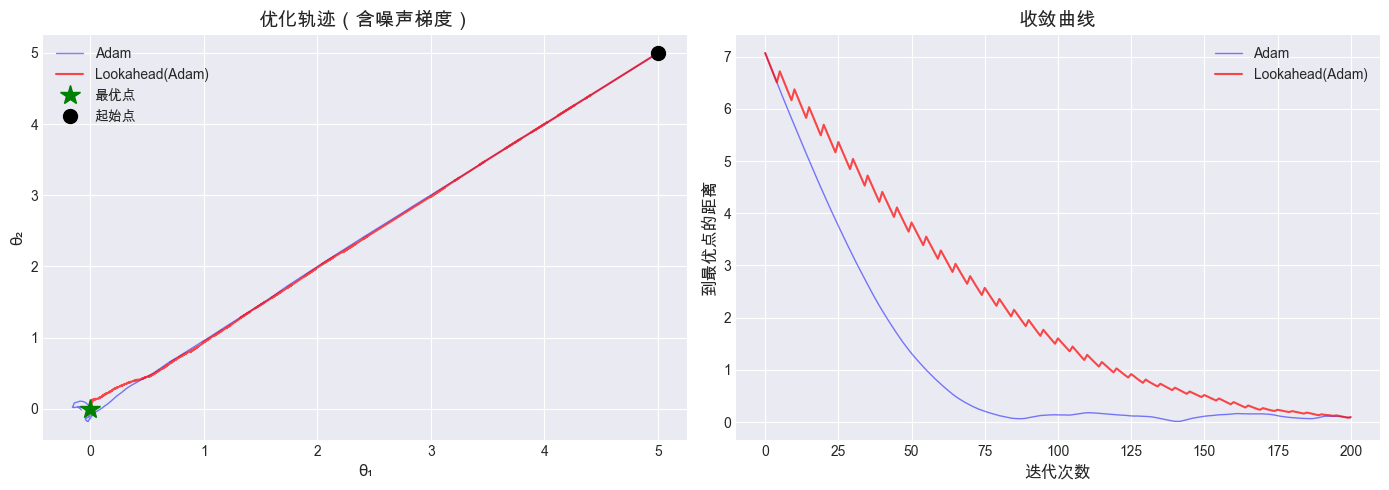

最终到最优点的距离：
  Adam:           0.080256
  Lookahead(Adam): 0.098161

Lookahead通过'慢权重'机制，减少了噪声的影响


In [17]:
# 比较Adam vs Lookahead(Adam)
def compare_lookahead():
    """
    比较纯Adam和Lookahead包装的Adam
    """
    # 使用一个有噪声的二次函数
    def noisy_loss(theta, noise_scale=0.5):
        base_loss = 0.5 * np.sum(theta**2)
        noise = noise_scale * np.random.randn()
        return base_loss + noise
    
    def noisy_grad(theta, noise_scale=0.5):
        base_grad = theta
        noise = noise_scale * np.random.randn(*theta.shape)
        return base_grad + noise
    
    np.random.seed(42)
    
    # 初始参数
    theta_init = np.array([5.0, 5.0])
    n_steps = 200
    
    # 纯Adam
    adam = Adam(learning_rate=0.1)
    theta_adam = theta_init.copy()
    history_adam = [theta_adam.copy()]
    
    for _ in range(n_steps):
        grad = noisy_grad(theta_adam)
        theta_adam = adam.update(theta_adam, grad)
        history_adam.append(theta_adam.copy())
    
    # Lookahead(Adam)
    np.random.seed(42)  # 重置随机种子，确保公平比较
    base_adam = Adam(learning_rate=0.1)
    lookahead = Lookahead(base_adam, k=5, alpha=0.5)
    theta_la = theta_init.copy()
    history_la = [theta_la.copy()]
    
    for _ in range(n_steps):
        grad = noisy_grad(theta_la)
        theta_la = lookahead.update(theta_la, grad)
        history_la.append(theta_la.copy())
    
    history_adam = np.array(history_adam)
    history_la = np.array(history_la)
    
    # 可视化
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左图：参数轨迹
    ax1 = axes[0]
    ax1.plot(history_adam[:, 0], history_adam[:, 1], 'b-', alpha=0.5, 
             label='Adam', linewidth=1)
    ax1.plot(history_la[:, 0], history_la[:, 1], 'r-', alpha=0.7, 
             label='Lookahead(Adam)', linewidth=1.5)
    ax1.plot(0, 0, 'g*', markersize=15, label='最优点')
    ax1.plot(theta_init[0], theta_init[1], 'ko', markersize=10, label='起始点')
    
    ax1.set_xlabel('θ₁', fontsize=12)
    ax1.set_ylabel('θ₂', fontsize=12)
    ax1.set_title('优化轨迹（含噪声梯度）', fontsize=14)
    ax1.legend()
    
    # 右图：到原点的距离
    ax2 = axes[1]
    dist_adam = np.sqrt(np.sum(history_adam**2, axis=1))
    dist_la = np.sqrt(np.sum(history_la**2, axis=1))
    
    ax2.plot(dist_adam, 'b-', alpha=0.5, label='Adam', linewidth=1)
    ax2.plot(dist_la, 'r-', alpha=0.7, label='Lookahead(Adam)', linewidth=1.5)
    
    ax2.set_xlabel('迭代次数', fontsize=12)
    ax2.set_ylabel('到最优点的距离', fontsize=12)
    ax2.set_title('收敛曲线', fontsize=14)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"最终到最优点的距离：")
    print(f"  Adam:           {dist_adam[-1]:.6f}")
    print(f"  Lookahead(Adam): {dist_la[-1]:.6f}")
    print("\nLookahead通过'慢权重'机制，减少了噪声的影响")

compare_lookahead()

---

## 6. 损失函数景观可视化

### 6.1 为什么要可视化损失景观？

损失函数景观（Loss Landscape）可以帮助我们理解：
- 为什么某些优化器更有效
- 网络的泛化能力
- 不同架构/正则化方法的效果

研究表明，更"平坦"的损失景观通常对应更好的泛化能力。

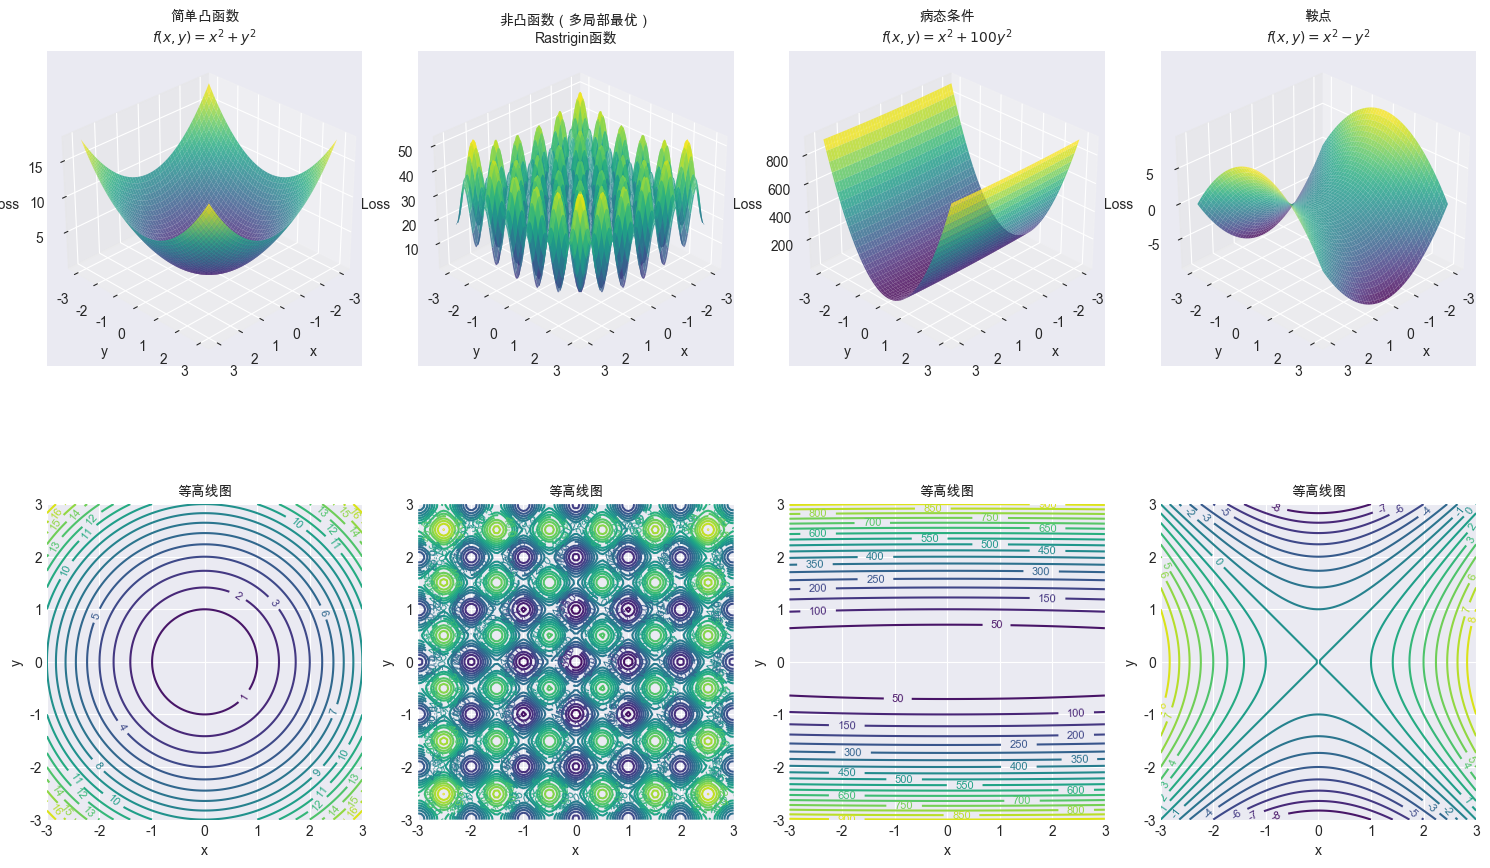

损失景观特征分析：

1. 简单凸函数: 任何优化器都能找到全局最优
2. 非凸函数: 容易陷入局部最优，需要好的初始化或动量
3. 病态条件: 不同方向的曲率差异大，需要自适应学习率
4. 鞍点: 梯度为零但不是最优点，动量可以帮助逃离


In [18]:
def visualize_loss_landscape():
    """
    可视化不同损失函数的景观
    
    展示：
    1. 简单二次损失（凸函数，单一最优点）
    2. 非凸损失（多个局部最优）
    3. 病态条件（长椭圆形，难以优化）
    """
    fig = plt.figure(figsize=(15, 10))
    
    # 创建网格
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    
    # 1. 简单二次损失（凸函数）
    Z1 = X**2 + Y**2
    
    # 2. 非凸损失（多个局部最优）
    # Rastrigin函数
    Z2 = 20 + X**2 + Y**2 - 10*(np.cos(2*np.pi*X) + np.cos(2*np.pi*Y))
    
    # 3. 病态条件（长椭圆形）
    Z3 = X**2 + 100*Y**2
    
    # 4. 带鞍点的景观
    Z4 = X**2 - Y**2
    
    landscapes = [
        (Z1, '简单凸函数\n$f(x,y) = x^2 + y^2$'),
        (Z2, '非凸函数（多局部最优）\nRastrigin函数'),
        (Z3, '病态条件\n$f(x,y) = x^2 + 100y^2$'),
        (Z4, '鞍点\n$f(x,y) = x^2 - y^2$')
    ]
    
    for idx, (Z, title) in enumerate(landscapes):
        # 3D图
        ax1 = fig.add_subplot(2, 4, idx + 1, projection='3d')
        ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, 
                         linewidth=0, antialiased=True)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_zlabel('Loss')
        ax1.set_title(title, fontsize=10)
        ax1.view_init(elev=30, azim=45)
        
        # 等高线图
        ax2 = fig.add_subplot(2, 4, idx + 5)
        contour = ax2.contour(X, Y, Z, levels=20, cmap='viridis')
        ax2.clabel(contour, inline=True, fontsize=8)
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_title('等高线图', fontsize=10)
        ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    print("损失景观特征分析：")
    print("\n1. 简单凸函数: 任何优化器都能找到全局最优")
    print("2. 非凸函数: 容易陷入局部最优，需要好的初始化或动量")
    print("3. 病态条件: 不同方向的曲率差异大，需要自适应学习率")
    print("4. 鞍点: 梯度为零但不是最优点，动量可以帮助逃离")

visualize_loss_landscape()

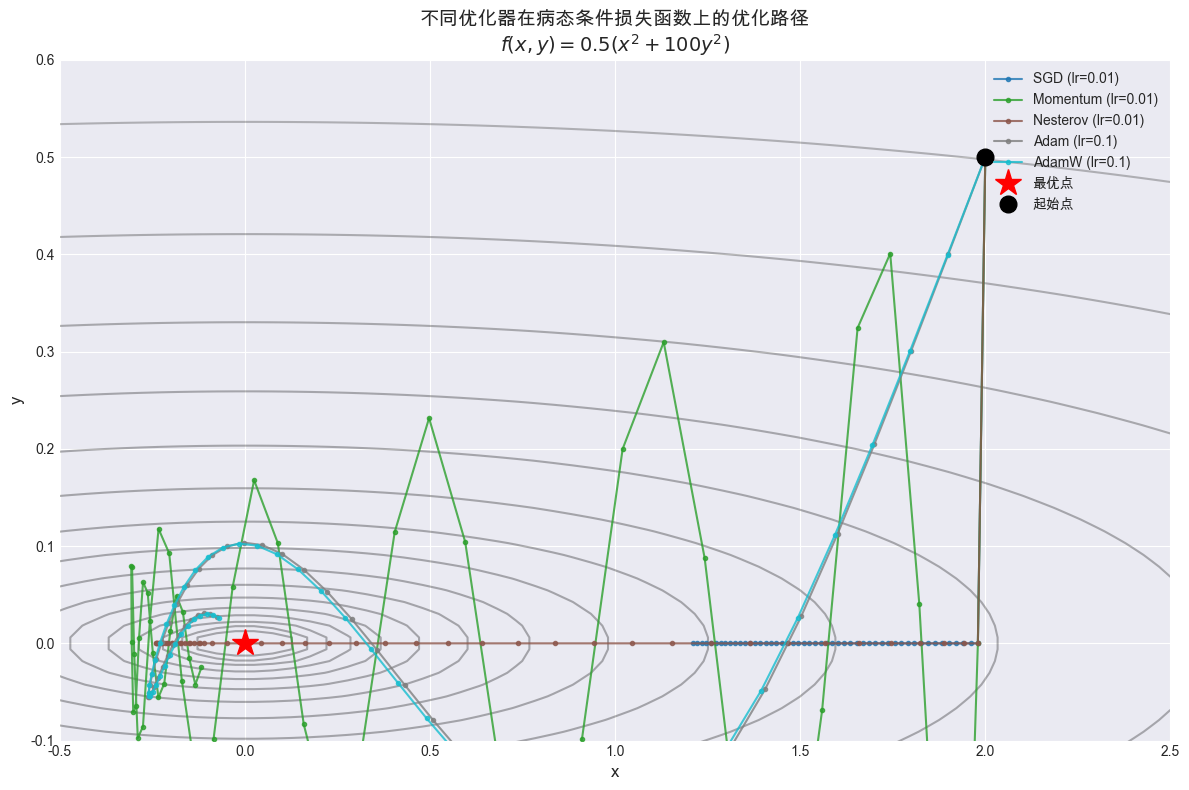

观察结论：
- SGD在病态条件下收敛很慢（z字形震荡）
- 动量可以加速收敛，但可能震荡
- Nesterov动量比标准动量更稳定
- Adam等自适应方法在病态条件下表现更好


In [19]:
# 在神经网络损失景观上可视化优化路径
def visualize_optimization_paths():
    """
    在不同损失景观上比较各种优化器的路径
    """
    # 使用病态条件的二次函数（椭圆形）
    # f(x,y) = 0.5 * (x^2 + 100*y^2)
    def loss_func(theta):
        return 0.5 * (theta[0]**2 + 100 * theta[1]**2)
    
    def grad_func(theta):
        return np.array([theta[0], 100 * theta[1]])
    
    # 初始点
    start = np.array([2.0, 0.5])
    n_steps = 50
    
    # 不同优化器
    optimizers = {
        'SGD (lr=0.01)': lambda: SGDSimple(0.01),
        'Momentum (lr=0.01)': lambda: StandardMomentum(0.01, 0.9),
        'Nesterov (lr=0.01)': lambda: NesterovMomentum(0.01, 0.9),
        'Adam (lr=0.1)': lambda: Adam(0.1),
        'AdamW (lr=0.1)': lambda: AdamW(0.1, weight_decay=0.01),
    }
    
    # 简单SGD类
    class SGDSimple:
        def __init__(self, lr):
            self.lr = lr
        def update(self, params, grads):
            return params - self.lr * grads
        def get_lookahead_position(self, params):
            return params
    
    # 运行各优化器
    histories = {}
    
    for name, opt_factory in optimizers.items():
        opt = opt_factory()
        theta = start.copy()
        history = [theta.copy()]
        
        for _ in range(n_steps):
            if hasattr(opt, 'get_lookahead_position'):
                lookahead = opt.get_lookahead_position(theta)
                grads = grad_func(lookahead)
            else:
                grads = grad_func(theta)
            theta = opt.update(theta, grads)
            history.append(theta.copy())
        
        histories[name] = np.array(history)
    
    # 可视化
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 绘制等高线
    x = np.linspace(-2.5, 2.5, 100)
    y = np.linspace(-0.6, 0.6, 100)
    X, Y = np.meshgrid(x, y)
    Z = 0.5 * (X**2 + 100 * Y**2)
    
    ax.contour(X, Y, Z, levels=np.logspace(-2, 2, 20), cmap='gray', alpha=0.3)
    
    # 绘制优化路径
    colors = plt.cm.tab10(np.linspace(0, 1, len(optimizers)))
    
    for (name, history), color in zip(histories.items(), colors):
        ax.plot(history[:, 0], history[:, 1], '-o', label=name, 
                color=color, markersize=3, linewidth=1.5, alpha=0.8)
    
    ax.plot(0, 0, 'r*', markersize=20, label='最优点')
    ax.plot(start[0], start[1], 'ko', markersize=12, label='起始点')
    
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title('不同优化器在病态条件损失函数上的优化路径\n$f(x,y) = 0.5(x^2 + 100y^2)$', fontsize=14)
    ax.legend(loc='upper right')
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.1, 0.6)
    
    plt.tight_layout()
    plt.show()
    
    print("观察结论：")
    print("- SGD在病态条件下收敛很慢（z字形震荡）")
    print("- 动量可以加速收敛，但可能震荡")
    print("- Nesterov动量比标准动量更稳定")
    print("- Adam等自适应方法在病态条件下表现更好")

visualize_optimization_paths()

---

## 7. 总结与最佳实践

### 7.1 损失函数选择指南

| 场景 | 推荐损失函数 |
|------|-------------|
| 标准分类 | 交叉熵 |
| 类别不平衡 | Focal Loss |
| 知识蒸馏 | KL散度 |
| 回归任务 | MSE / Huber Loss |
| 生成模型 | KL散度 / JS散度 |

### 7.2 优化器选择指南

| 场景 | 推荐优化器 |
|------|----------|
| 默认选择 | AdamW |
| 大规模训练 | AdamW + 学习率调度 |
| 需要稳定性 | Lookahead(Adam) |
| 简单问题 | SGD + Momentum |
| 不想调warmup | RAdam |

### 7.3 关键要点

1. **KL散度**是非对称的，适合衡量分布差异
2. **JS散度**是对称且有界的，更稳定
3. **Focal Loss**通过调制因子降低简单样本的权重
4. **Nesterov**动量通过"lookahead"提前预测方向
5. **AdamW**的权重衰减与L2正则化在数学上不等价
6. **Lookahead**通过慢权重机制提高稳定性

---

## 8. 练习题

### 练习1：KL散度计算

给定两个概率分布：
- P = [0.3, 0.4, 0.2, 0.1]
- Q = [0.25, 0.25, 0.25, 0.25]

计算 $D_{KL}(P||Q)$ 和 $D_{KL}(Q||P)$，并解释为什么它们不同。

### 练习2：实现Focal Loss

在一个不平衡数据集上（正负样本比1:10），比较交叉熵和Focal Loss的训练效果。

### 练习3：优化器比较

在MNIST数据集上训练一个简单的神经网络，比较以下优化器的收敛速度和最终准确率：
1. SGD
2. SGD + Momentum
3. Adam
4. AdamW

### 练习4（挑战）：实现RAdam

查阅RAdam论文，实现RAdam优化器，并与Adam进行对比。

In [ ]:
# 练习答案区域（供学习者填写）

# 练习1答案
def exercise_1():
    """
    计算KL散度并解释非对称性
    """
    # 在这里填写你的代码
    pass

# 练习2答案
def exercise_2():
    """
    在不平衡数据集上比较交叉熵和Focal Loss
    """
    # 在这里填写你的代码
    pass

print("练习区域已准备好，请开始编写代码！")

---

## 参考资料

1. **Focal Loss**: Lin et al., "Focal Loss for Dense Object Detection" (2017)
2. **AdamW**: Loshchilov & Hutter, "Decoupled Weight Decay Regularization" (2019)
3. **RAdam**: Liu et al., "On the Variance of the Adaptive Learning Rate and Beyond" (2020)
4. **Lookahead**: Zhang et al., "Lookahead Optimizer: k steps forward, 1 step back" (2019)
5. **Loss Landscape**: Li et al., "Visualizing the Loss Landscape of Neural Nets" (2018)

---

**下一章预告**: 06b_bias_variance.ipynb - 偏差-方差分解详解